* In the dataset there is no label column is available and from the problem statement it is clearly visible that it is a unsupervised learning problem where we need to segmentise the customer.
* Here we will use RFM (Recency, Frequency and Monetary) analysis + K-Mean clustering for the customer segemenataion.

In [1]:
#Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import matplotlib.pyplot  as plt

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

## DATA COLLECTION

In [2]:
df=pd.read_csv('data.csv',encoding= 'unicode_escape')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12-01-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12-01-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12-01-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12-01-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12-01-2010 08:26,3.39,17850.0,United Kingdom


# EDA

## DATA CLEANING

In [3]:
df.shape

(541909, 8)

In [4]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

* Droping of null values:
<ul>
  <li> I am droping the null values becasuse without customer id we can't track the customer & without the description it is not possible to know what product they are buying. So we don't need these rows. if i will not remove it will affect my analysis.
<ul>

In [5]:
df.dropna(inplace=True)
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

* In the dataset only price and quantity is available but total price is not available so i am adding one column Amount which will calculate total price. Total price= UnitPrice * Quantity

In [6]:
df['Amount']=df['Quantity']*df['UnitPrice']

In [7]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'Amount'],
      dtype='object')

In [8]:
df['CustomerID'].value_counts()

17841.0    7983
14911.0    5903
14096.0    5128
12748.0    4642
14606.0    2782
           ... 
15070.0       1
15753.0       1
17065.0       1
16881.0       1
16995.0       1
Name: CustomerID, Length: 4372, dtype: int64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    406829 non-null  object 
 1   StockCode    406829 non-null  object 
 2   Description  406829 non-null  object 
 3   Quantity     406829 non-null  int64  
 4   InvoiceDate  406829 non-null  object 
 5   UnitPrice    406829 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      406829 non-null  object 
 8   Amount       406829 non-null  float64
dtypes: float64(3), int64(1), object(5)
memory usage: 31.0+ MB


<ul>
    <li>Object feature: InvoiceNo,StockCode,Description,InvoiceDate,Country
    <li>float/int feature: Quantity, UnitPrice, CustomerID, Amount
<ul>

In [10]:
df.describe()

,Quantity,UnitPrice,CustomerID,Amount
count,406829.000000,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570,20.401854
std,248.693370,69.315162,1713.600303,427.591718
min,-80995.000000,0.000000,12346.000000,-168469.600000
25%,2.000000,1.250000,13953.000000,4.200000
50%,5.000000,1.950000,15152.000000,11.100000
75%,12.000000,3.750000,16791.000000,19.500000
max,80995.000000,38970.000000,18287.000000,168469.600000


* In the quanitity and Amount columns we are getting the negative values which is not making any conclusion so i am removing these values

In [11]:
df1=df[df['Quantity']>0]

In [12]:
df1.describe()

,Quantity,UnitPrice,CustomerID,Amount
count,397924.000000,397924.000000,397924.000000,397924.000000
mean,13.021823,3.116174,15294.315171,22.394749
std,180.420210,22.096788,1713.169877,309.055588
min,1.000000,0.000000,12346.000000,0.000000
25%,2.000000,1.250000,13969.000000,4.680000
50%,6.000000,1.950000,15159.000000,11.800000
75%,12.000000,3.750000,16795.000000,19.800000
max,80995.000000,8142.750000,18287.000000,168469.600000


## RFM ANALYSIS

* RFM metrics plays a vital role in the understanding of the customer behaviour as frequency and monetary value affect a customer’s lifetime value, and recency affects retention, a measure of engagement.

In [13]:
# I want to know the how much each customer spending in purchase by using groupby method
monetary = df1.groupby('CustomerID')['Amount'].sum()
monetary=monetary.reset_index()
monetary.head()

,CustomerID,Amount
0,12346.0,77183.60
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [14]:
frequency=df1.groupby('CustomerID')['InvoiceNo'].count()
frequency=frequency.reset_index()
frequency.head()

,CustomerID,InvoiceNo
0,12346.0,1
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


* Recency is calculated by substracting the very recent date with last transaction date with customer

In [15]:
df1['InvoiceDate']=pd.to_datetime(df1['InvoiceDate'])

C:\Users\Srikanta\AppData\Local\Temp\ipykernel_20472\563338608.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['InvoiceDate']=pd.to_datetime(df1['InvoiceDate'])


In [16]:
df1['InvoiceDate']

0        2010-12-01 08:26:00
1        2010-12-01 08:26:00
2        2010-12-01 08:26:00
3        2010-12-01 08:26:00
4        2010-12-01 08:26:00
                 ...        
541904   2011-12-09 12:50:00
541905   2011-12-09 12:50:00
541906   2011-12-09 12:50:00
541907   2011-12-09 12:50:00
541908   2011-12-09 12:50:00
Name: InvoiceDate, Length: 397924, dtype: datetime64[ns]

In [17]:
df1['diff']=max(df1['InvoiceDate'])-df1['InvoiceDate']
recency=df1.groupby('CustomerID')['diff'].min()

C:\Users\Srikanta\AppData\Local\Temp\ipykernel_20472\4091361809.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['diff']=max(df1['InvoiceDate'])-df1['InvoiceDate']


In [18]:
recency=recency.reset_index()
recency.head()

,CustomerID,diff
0,12346.0,325 days 02:49:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [19]:
recency['diff']=recency['diff'].dt.days

In [20]:
recency.head()

,CustomerID,diff
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


* We have calculated recency, frequecy & monetary now to merge all the result for better understanding

In [21]:
rfm=pd.merge(recency,frequency,on='CustomerID', how='inner')
rfm=pd.merge(rfm,monetary,on='CustomerID', how='inner')

In [22]:
rfm

,CustomerID,diff,InvoiceNo,Amount
0,12346.0,325,1,77183.60
1,12347.0,1,182,4310.00
2,12348.0,74,31,1797.24
3,12349.0,18,73,1757.55
4,12350.0,309,17,334.40
...,...,...,...,...
4334,18280.0,277,10,180.60
4335,18281.0,180,7,80.82
4336,18282.0,7,12,178.05
4337,18283.0,3,756,2094.88


In [23]:
rfm.columns=['CustomerId','Recency','Frequency','Monetary']

In [24]:
rfm.head()

,CustomerId,Recency,Frequency,Monetary
0,12346.0,325,1,77183.60
1,12347.0,1,182,4310.00
2,12348.0,74,31,1797.24
3,12349.0,18,73,1757.55
4,12350.0,309,17,334.40


## Outlier Detection

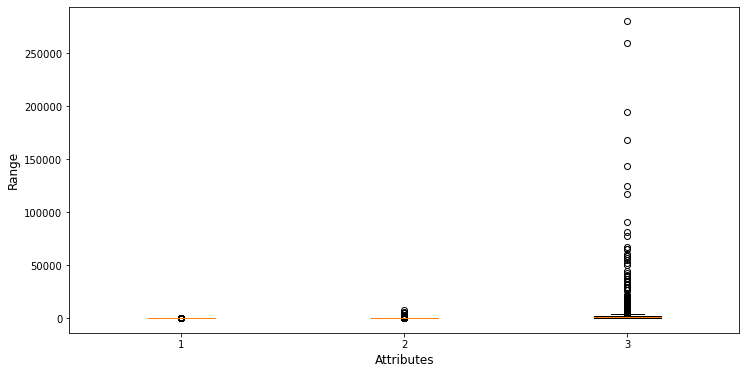

In [25]:
# To detect the outlier in the dataset i will use the box plot
#Outlier Detection
plt.figure(figsize=(12,6))
plt.boxplot(rfm[['Recency','Frequency','Monetary']])
plt.xlabel('Attributes',fontsize=12)
plt.ylabel('Range',fontsize=12)
plt.show()

### Recency

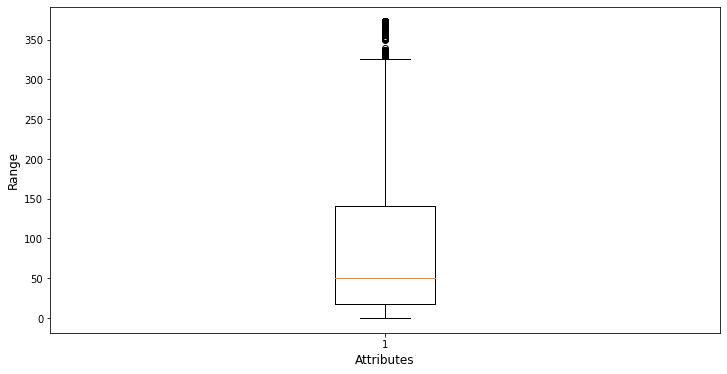

In [26]:
plt.figure(figsize=(12,6))
plt.boxplot(rfm['Recency'])
plt.xlabel('Attributes',fontsize=12)
plt.ylabel('Range',fontsize=12)
plt.show()

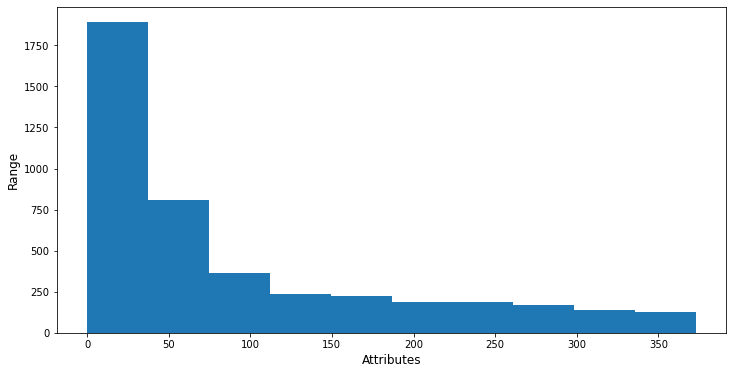

In [27]:
plt.figure(figsize=(12,6))
plt.hist(rfm['Recency'])
plt.xlabel('Attributes',fontsize=12)
plt.ylabel('Range',fontsize=12)
plt.show()

### Frequency

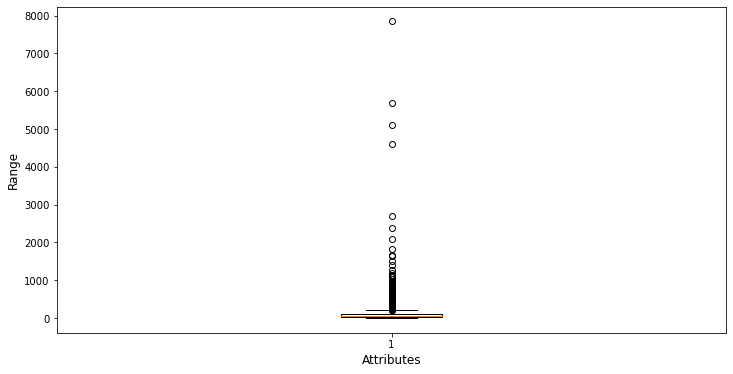

In [28]:
plt.figure(figsize=(12,6))
plt.boxplot(rfm['Frequency'])
plt.xlabel('Attributes',fontsize=12)
plt.ylabel('Range',fontsize=12)
plt.show()

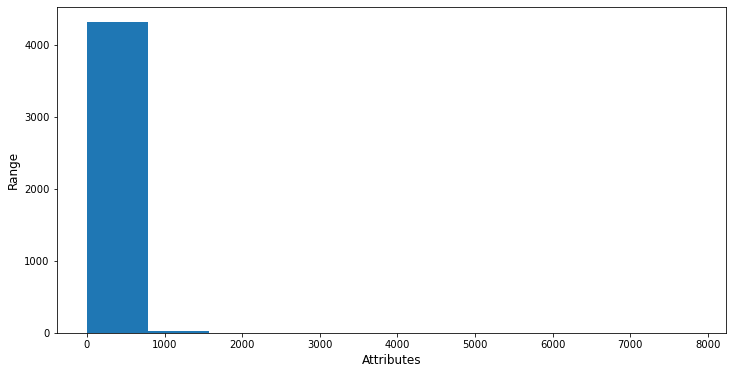

In [29]:
plt.figure(figsize=(12,6))
plt.hist(rfm['Frequency'])
plt.xlabel('Attributes',fontsize=12)
plt.ylabel('Range',fontsize=12)
plt.show()

### Monetary

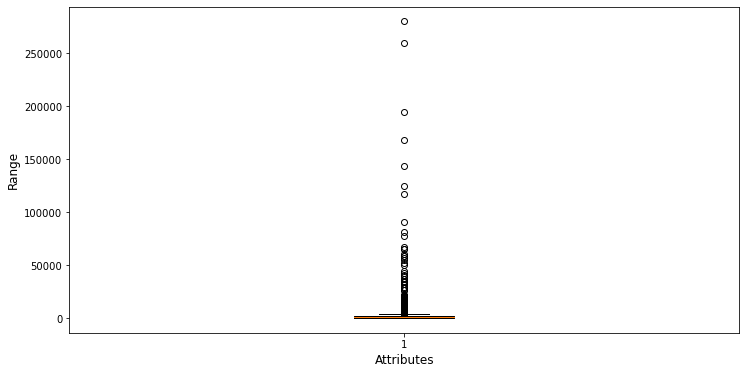

In [30]:
plt.figure(figsize=(12,6))
plt.boxplot(rfm['Monetary'])
plt.xlabel('Attributes',fontsize=12)
plt.ylabel('Range',fontsize=12)
plt.show()

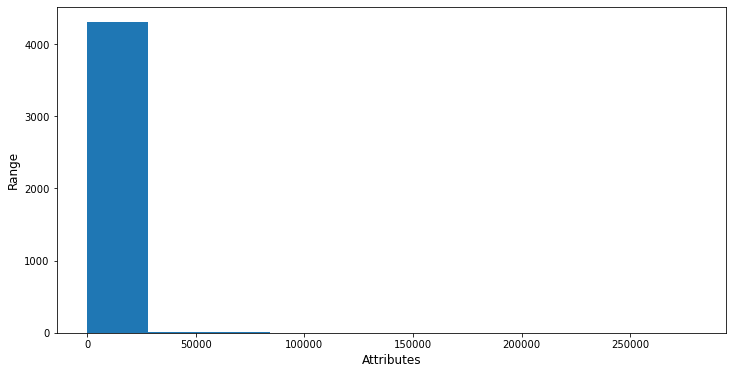

In [31]:
plt.figure(figsize=(12,6))
plt.hist(rfm['Monetary'])
plt.xlabel('Attributes',fontsize=12)
plt.ylabel('Range',fontsize=12)
plt.show()

* It is clealry visible from the graph that there is a outlier present in the dataset, i need to handle this outlier else it will affect my prediction

### Handle outliers using IQR

In [32]:
# Function to find the lower limit and upper limit
def find_boundries(df,variable):
    Q1=df[variable].quantile(0.25)
    Q3=df[variable].quantile(0.75)
    IQR=Q3-Q1
    lower_limit=Q1-1.5*IQR
    upper_limit=Q3+1.5*IQR
    
    return lower_limit, upper_limit

### Monetary

In [33]:
lower_limit_monetary,upper_limit_monetary=find_boundries(rfm,'Monetary')

In [34]:
lower_limit_monetary,upper_limit_monetary

(-1724.3474999999999, 3693.2325)

In [35]:
rfm_new=rfm[(rfm['Monetary']>lower_limit_monetary) & (rfm['Monetary']<upper_limit_monetary)]

In [36]:
rfm_new=rfm_new.reset_index(drop=True)
rfm_new.head()

,CustomerId,Recency,Frequency,Monetary
0,12348.0,74,31,1797.24
1,12349.0,18,73,1757.55
2,12350.0,309,17,334.40
3,12352.0,35,85,2506.04
4,12353.0,203,4,89.00


### Recency

In [37]:
lower_limit_monetary,upper_limit_monetary=find_boundries(rfm_new,'Recency')

In [38]:
lower_limit_monetary,upper_limit_monetary

(-183.0, 361.0)

In [39]:
rfm_new=rfm_new[(rfm_new['Recency']>lower_limit_monetary) & (rfm_new['Recency']<upper_limit_monetary)]

In [40]:
rfm_new=rfm_new.reset_index(drop=True)
rfm_new.head()

,CustomerId,Recency,Frequency,Monetary
0,12348.0,74,31,1797.24
1,12349.0,18,73,1757.55
2,12350.0,309,17,334.40
3,12352.0,35,85,2506.04
4,12353.0,203,4,89.00


## Frequency

In [41]:
lower_limit_monetary,upper_limit_monetary=find_boundries(rfm_new,'Frequency')

In [42]:
lower_limit_monetary,upper_limit_monetary

(-81.5, 178.5)

In [43]:
rfm_new=rfm_new[(rfm_new['Frequency']>lower_limit_monetary) & (rfm_new['Frequency']<upper_limit_monetary)]

In [44]:
rfm_new=rfm_new.reset_index(drop=True)
rfm_new.head()

,CustomerId,Recency,Frequency,Monetary
0,12348.0,74,31,1797.24
1,12349.0,18,73,1757.55
2,12350.0,309,17,334.40
3,12352.0,35,85,2506.04
4,12353.0,203,4,89.00


In [45]:
rfm_new.shape

(3582, 4)

### Box plot after cleaning the dataset

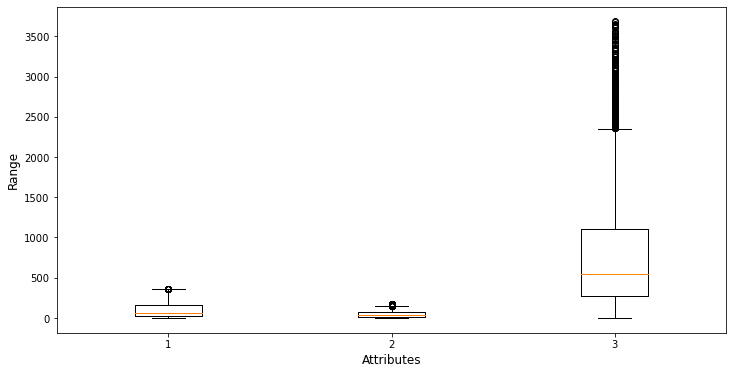

In [46]:
#Outlier Detection
plt.figure(figsize=(12,6))
plt.boxplot(rfm_new[['Recency','Frequency','Monetary']])
plt.xlabel('Attributes',fontsize=12)
plt.ylabel('Range',fontsize=12)
plt.show()

## K-Mean

In [47]:
scaler=StandardScaler()
rfm_normalized=rfm_new[['Recency','Frequency','Monetary']]
rfm_normalized

,Recency,Frequency,Monetary
0,74,31,1797.24
1,18,73,1757.55
2,309,17,334.40
3,35,85,2506.04
4,203,4,89.00
...,...,...,...
3577,73,9,173.90
3578,277,10,180.60
3579,180,7,80.82
3580,7,12,178.05


In [48]:
rfm_normalized=scaler.fit_transform(rfm_normalized)
rfm_normalized=pd.DataFrame(rfm_normalized)
rfm_normalized

,0,1,2
0,-0.243214,-0.385025,1.292084
1,-0.830284,0.629241,1.239811
2,2.220385,-0.723114,-0.634526
3,-0.652066,0.919031,2.225598
4,1.109145,-1.037053,-0.957727
...,...,...,...
3577,-0.253697,-0.916307,-0.845911
3578,1.884916,-0.892158,-0.837086
3579,0.868027,-0.964606,-0.968500
3580,-0.945601,-0.843860,-0.840445


Text(0, 0.5, 'Range')

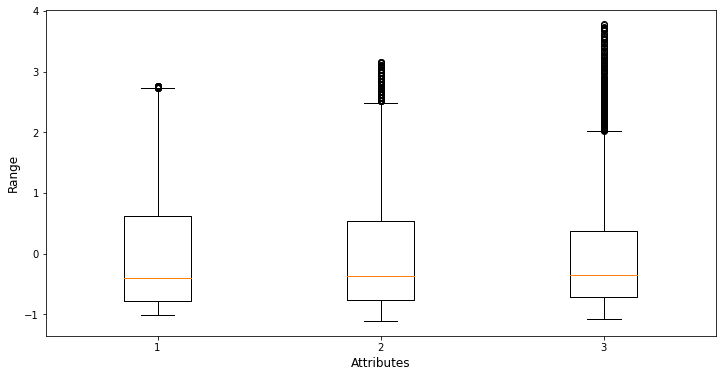

In [49]:
plt.figure(figsize=(12,6))
plt.boxplot(rfm_normalized)
plt.xlabel('Attributes',fontsize=12)
plt.ylabel('Range',fontsize=12)

In [50]:
wcss=[]
for num_cluster in range(1,10):
    kmeans=KMeans(n_clusters=num_cluster,max_iter=50)
    kmeans.fit(rfm_normalized)
    wcss.append(kmeans.inertia_)
    

Text(0, 0.5, 'wcss')

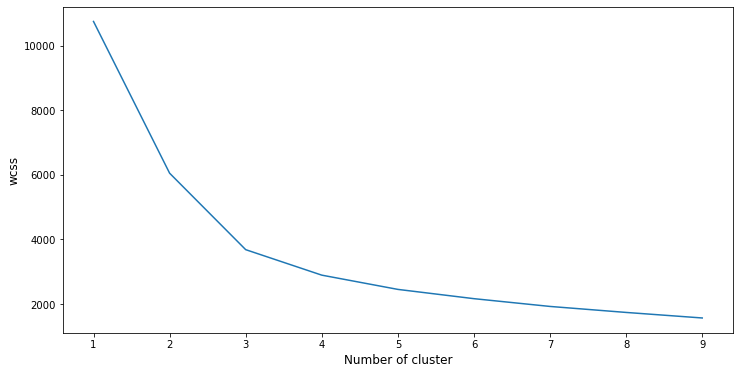

In [51]:
x=list(range(1,10))
plt.figure(figsize=(12,6))
plt.plot(x,wcss)
plt.xlabel('Number of cluster',fontsize=12)
plt.ylabel('wcss',fontsize=12)

* From the elbow method it is clear that the optimum number of cluster is three 

##  Conclusion: Total number of customer segment is THREE